In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import pairwise_distances
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import matplotlib.image as mpimg

# Data sources

In [3]:
visits = np.array([
    [20,  20],
    [100, 50],
    [200, 125],
    [250, 115]
])

In [4]:
img = mpimg.imread("./../../assets/gbgmap.png")
img = img[0:150, 0:300]

In [5]:
img.shape

(150, 300, 4)

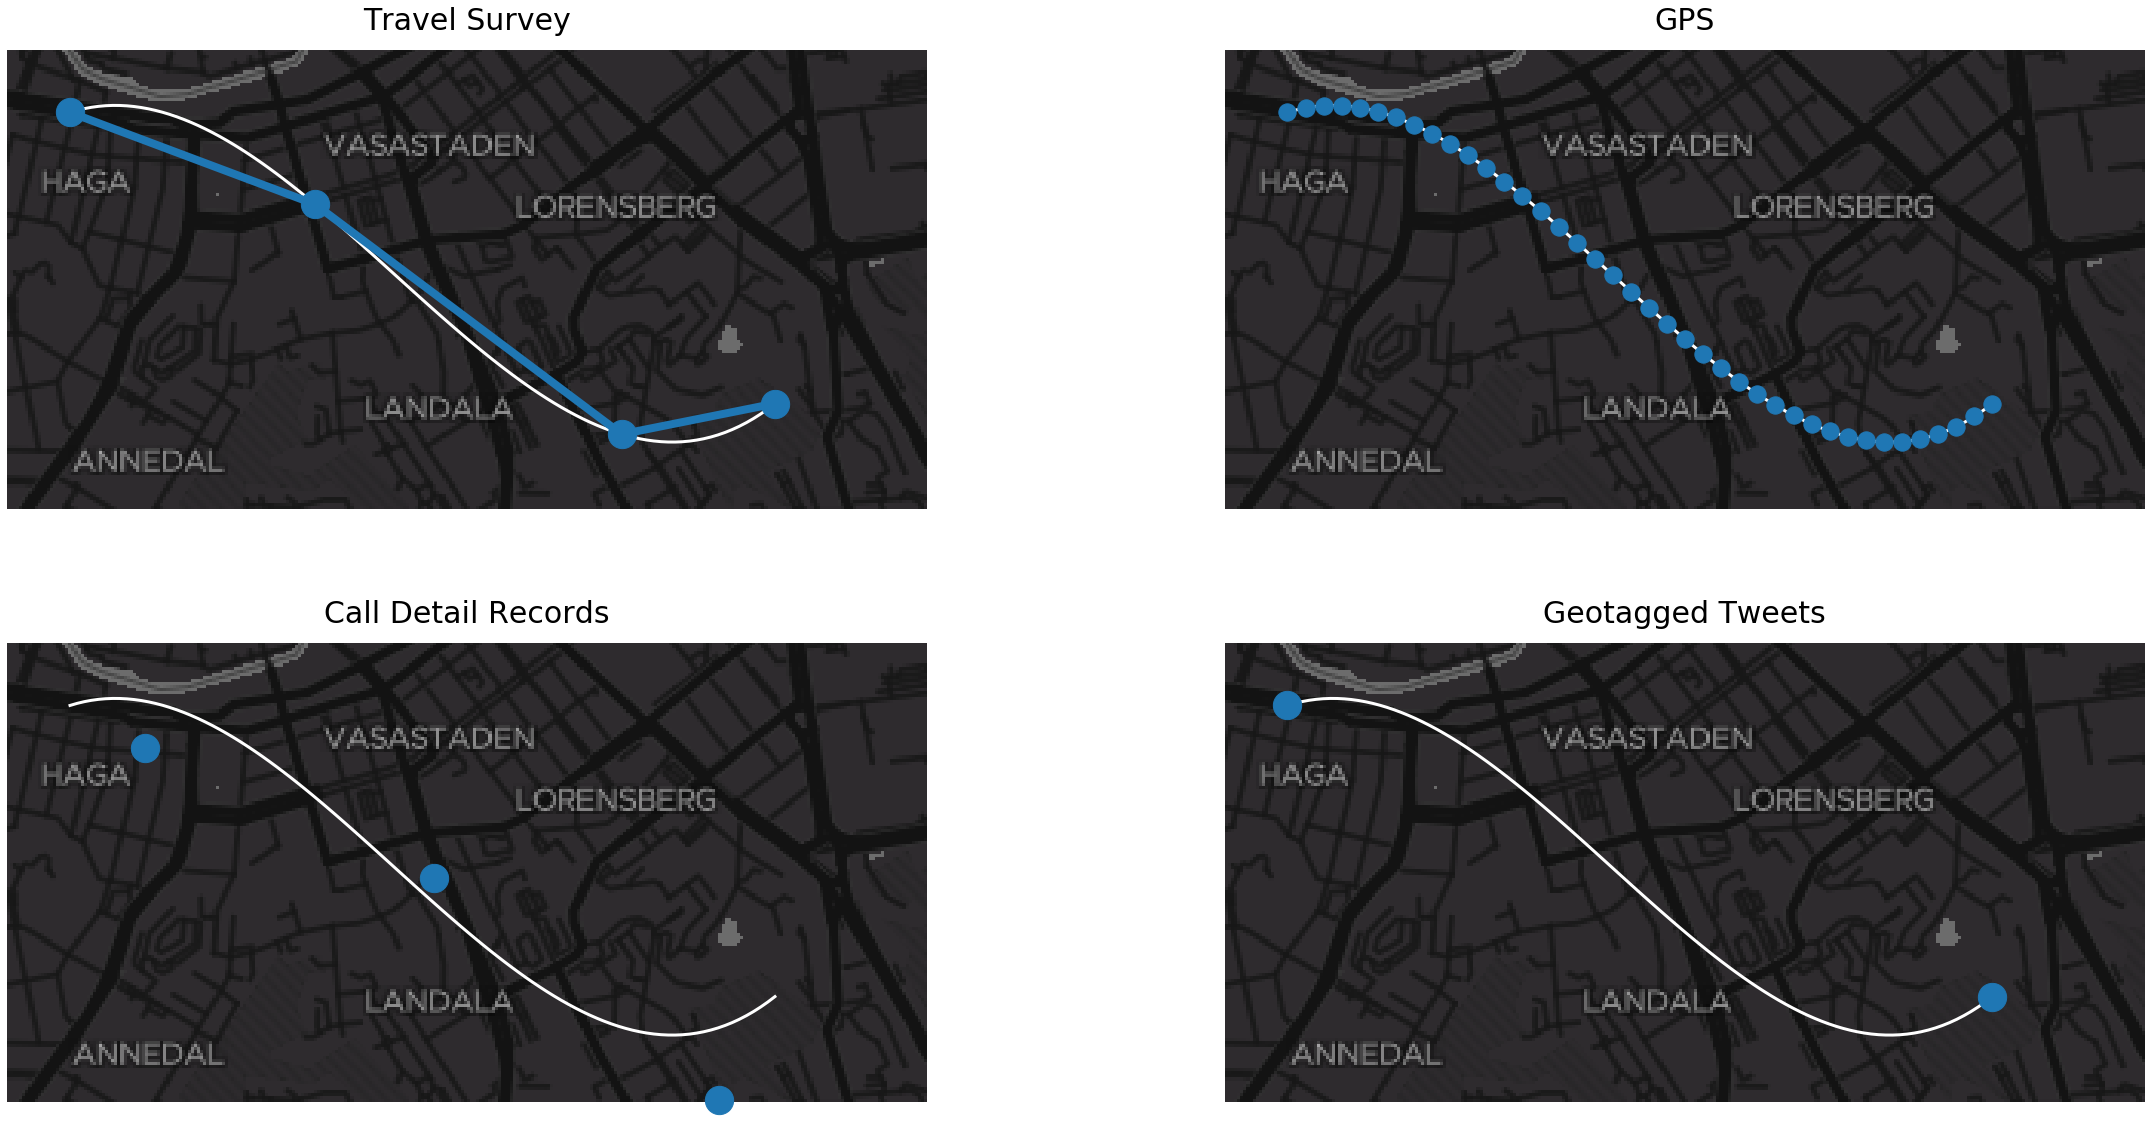

In [6]:
fig, axes = plt.subplots(2,2, figsize=(40,20), sharex=True, sharey=True)
interpol = interp1d(visits[:,0], visits[:,1], kind="cubic")

# True
x = np.linspace(20, 250, 100)
y = interpol(x)
for ax in [axes[0,0], axes[0,1], axes[1,0], axes[1,1]]:
    ax.imshow(img, zorder=-2)
    ax.plot(x,y, color="white", zorder=-1, linewidth=3)
    ax.set_axis_off()
#axes[0,0].scatter(visits[:,0], visits[:,1], s=200, zorder=3, color="black")

# Travel survey
axes[0,0].set_title("Travel Survey", fontsize=30, pad=20)
axes[0,0].plot(visits[:,0], visits[:,1], linewidth=8)
axes[0,0].scatter(visits[:,0], visits[:,1], s=800)

# GPS
axes[0,1].set_title("GPS", fontsize=30, pad=20)
xgps = np.linspace(20, 250, 40)
ygps = interpol(xgps)
axes[0,1].scatter(xgps, ygps, s=300)

# CDR
axes[1,0].set_title("Call Detail Records", fontsize=30, pad=20)
xcdr = np.linspace(40, 230, 3) + np.random.random_sample(3)*10-5
ycdr = interpol(xcdr) + np.random.random_sample(3)*60-30
axes[1,0].scatter(xcdr,ycdr, s=800)

# Twitter
axes[1,1].set_title("Geotagged Tweets", fontsize=30, pad=20)
tweets = np.array([visits[0], visits[3]])
axes[1,1].scatter(tweets[:,0], tweets[:,1], s=800, zorder=3)

# Model example

In [7]:
places = [
    (15, 10),
    (30,  5),
    (12, 13),
    (22, 12)
]

home_location = 0
visits = np.array([14, 12, 8, 3])
distances = pairwise_distances(places)

In [8]:
def visitation_freq():
    visitation_f = visits / np.sum(visits)
    pl = []
    for i, (x,y) in enumerate(places):
        size = visitation_f[i] * 5
        pl.append((
            x, y, 
            size, 
            (),
        ))
    return pl
    
    
def preferential_return(from_index):
    d = distances[from_index]
    impedance = np.exp(-0.1 * d)
    impedance = impedance / np.sum(impedance)
    visitation_freq = visits / np.sum(visits)
    s = impedance * visitation_freq
    s[from_index] = 0.05
    s = s / np.sum(s)
    
    pl = []
    for i, (x,y) in enumerate(places):
        size = 5*s[i]
        pl.append((
            x, y, 
            size, 
            (impedance[i], visitation_freq[i]),
        ))
    return pl

def uniform_size(state, size):
    n = []
    for (x,y,s,info) in state:
        n.append((x,y,size,info))
    return n

def plot(state, current_place=None):
    fig, ax = plt.subplots(1,1, figsize=(32,16))
    ax.set_xlim(0,32)
    ax.set_ylim(2,18)
    ax.set_axis_off()
    
    for i, (x, y, d, _) in enumerate(state):
        c = "C0"
        if current_place is not None and i == current_place:
            c = "C1"
        ax.add_artist(mpl.patches.Circle((x,y), d, color=c))
        if i == home_location:
            ax.text(x, y-d-1, "Home", fontsize=35, ha="center", va="center")
    return ax

def mark(ax, text, x, y):
    ax.text(x, y, text, fontsize=50, ha="center", va="center", fontweight="bold")
    
def mark_place(ax, text, place_index):
    mark(ax, text, places[place_index][0], places[place_index][1])

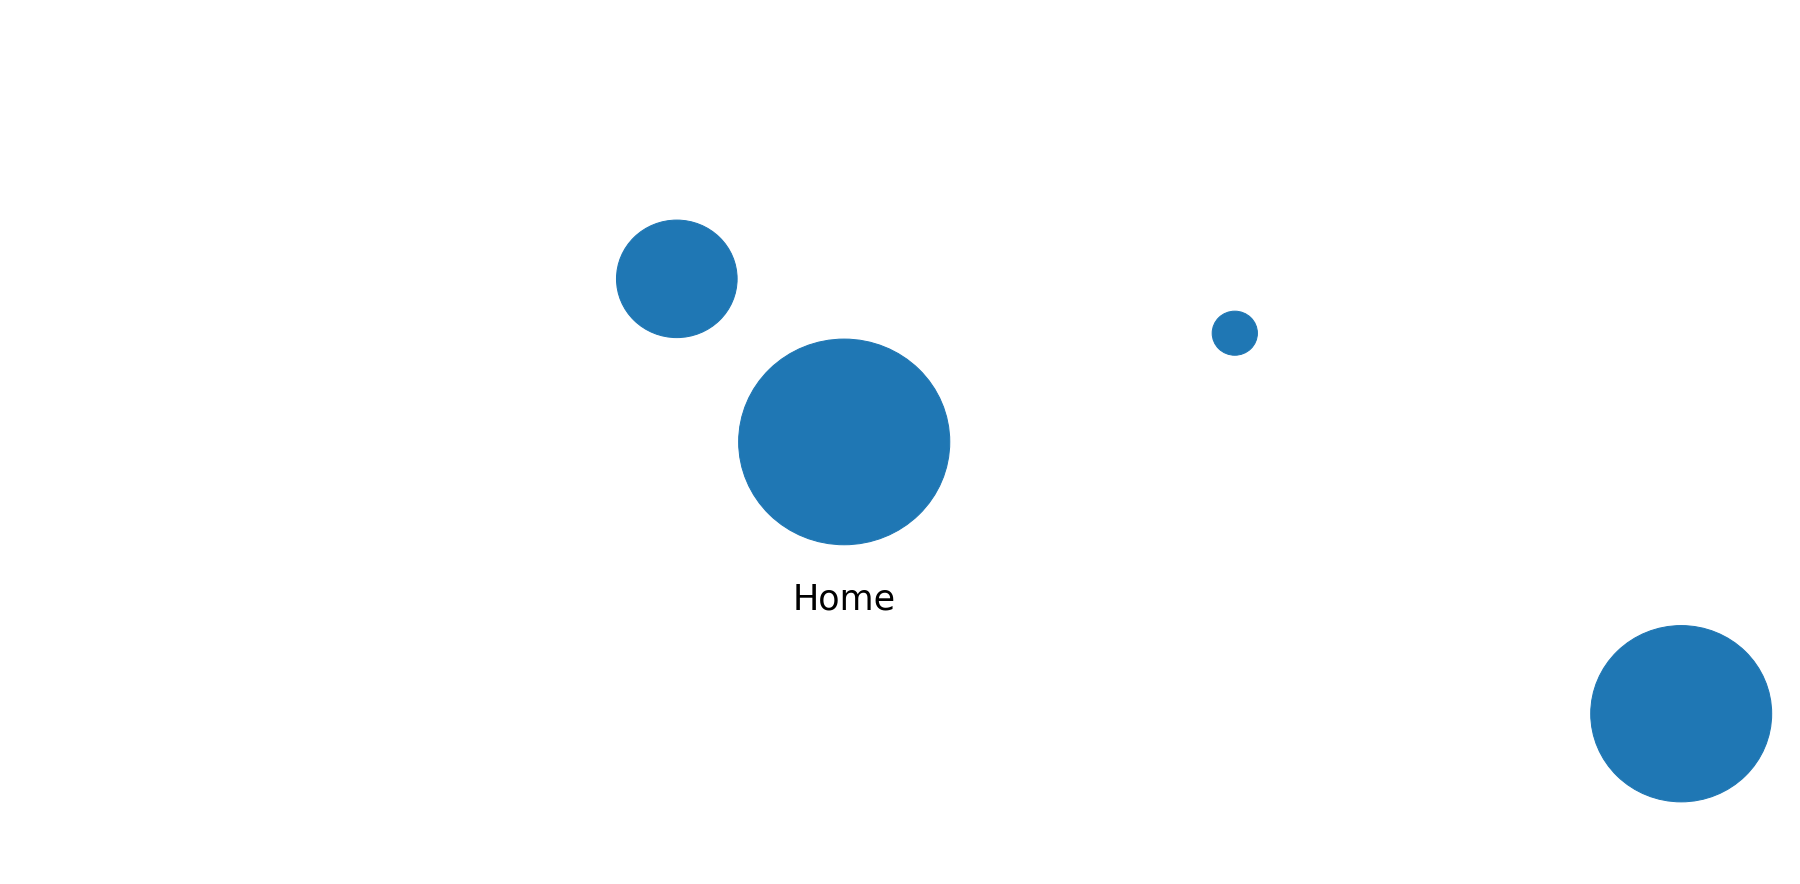

In [9]:
ax = plot(visitation_freq())

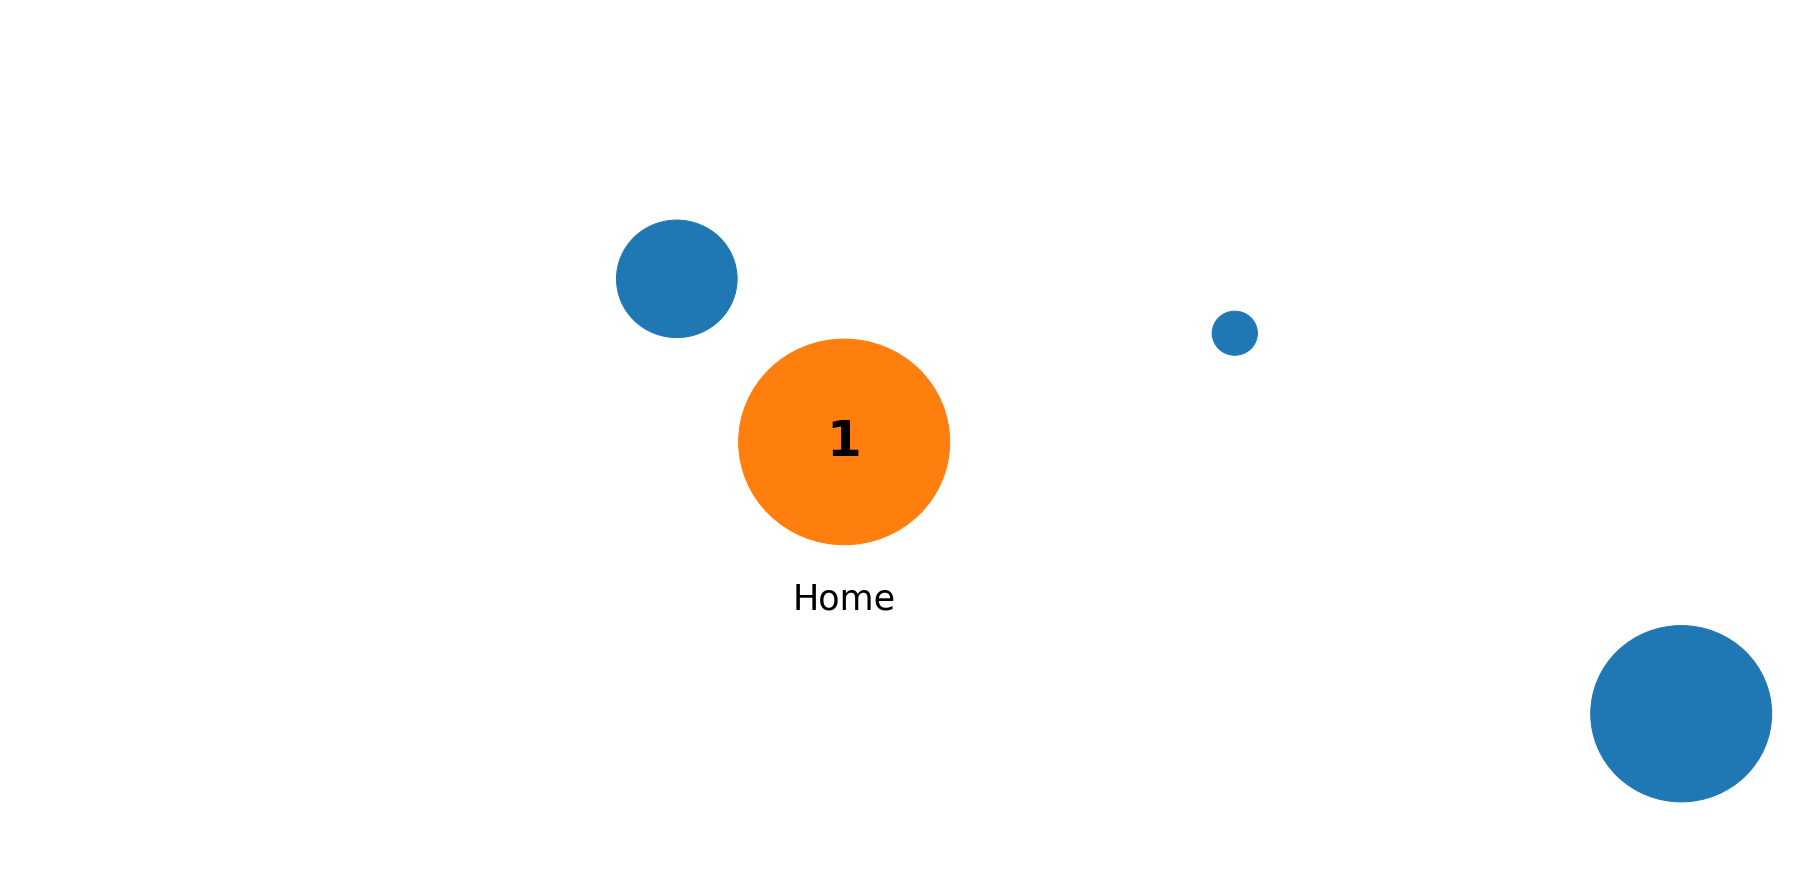

In [10]:
ax = plot(visitation_freq(), home_location)
mark_place(ax, "1", home_location)

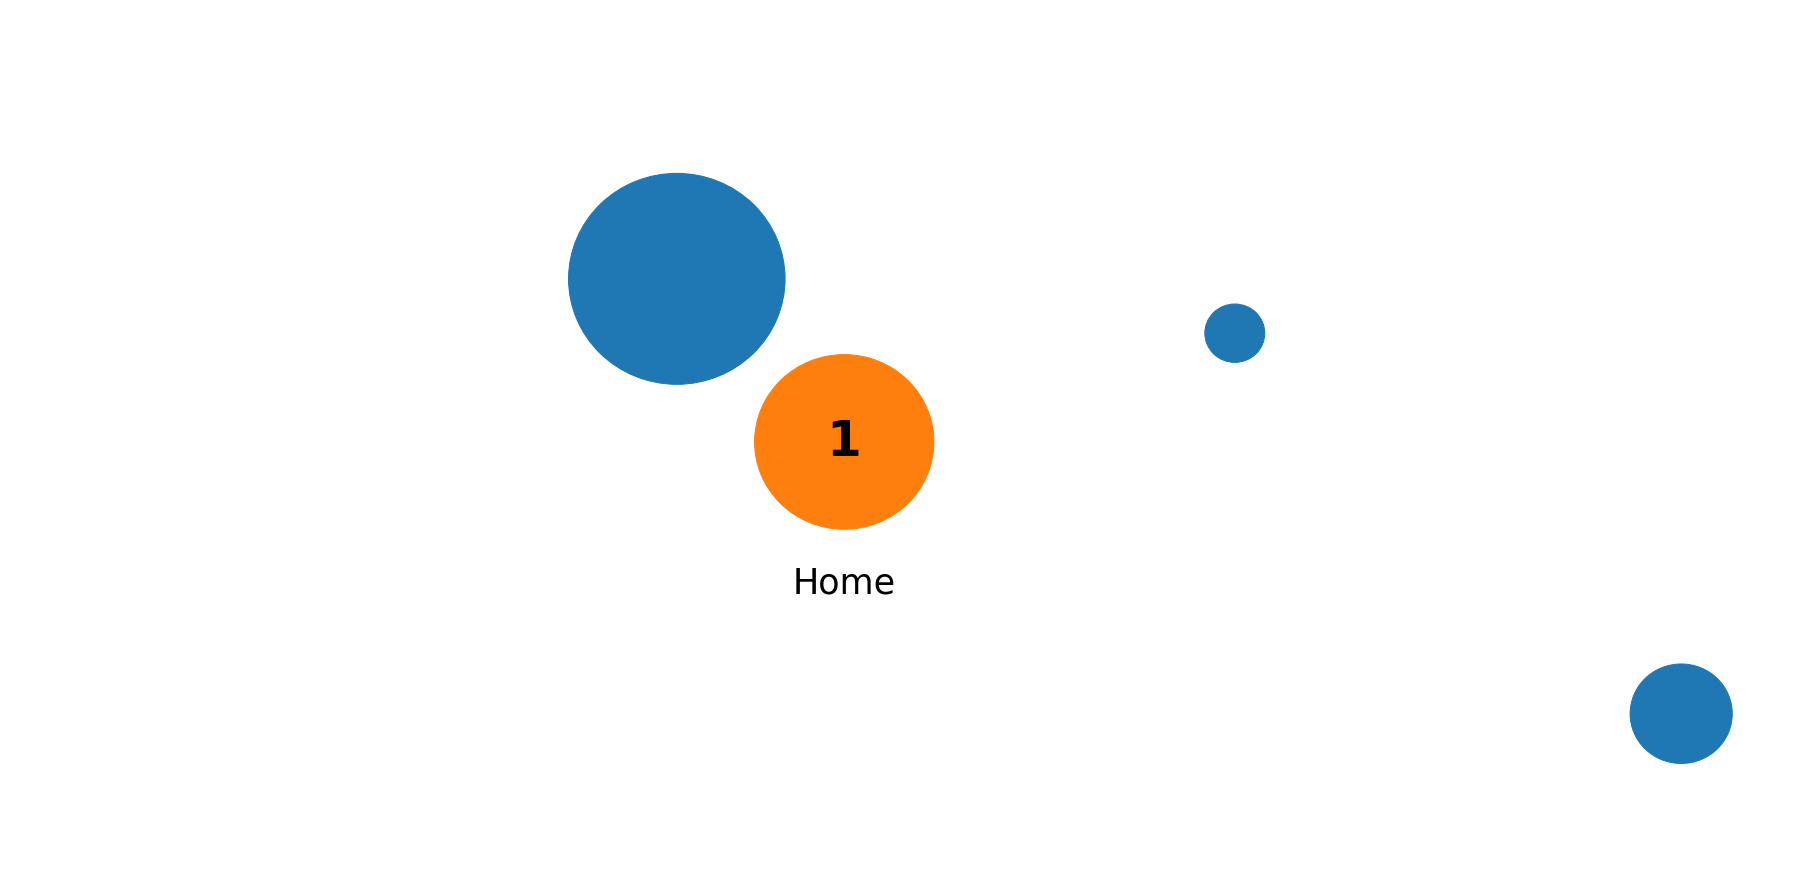

In [11]:
ax = plot(preferential_return(home_location), home_location)
mark_place(ax, "1", home_location)

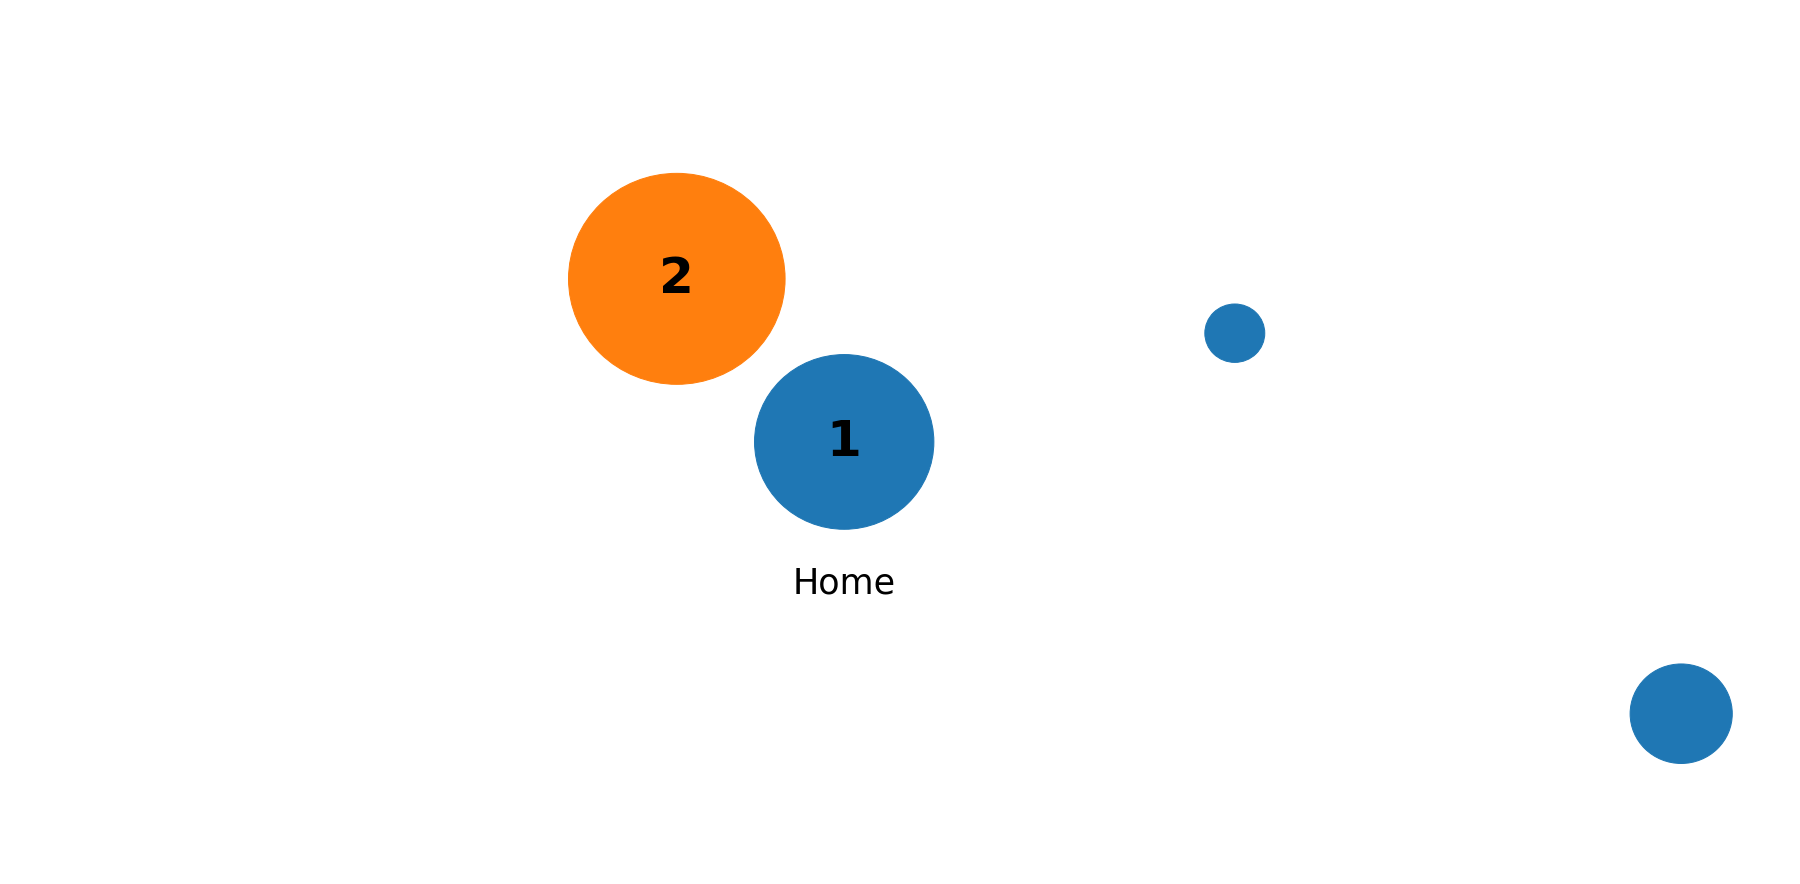

In [12]:
ax = plot(preferential_return(home_location), 2)
mark_place(ax, "1", home_location)
mark_place(ax, "2", 2)

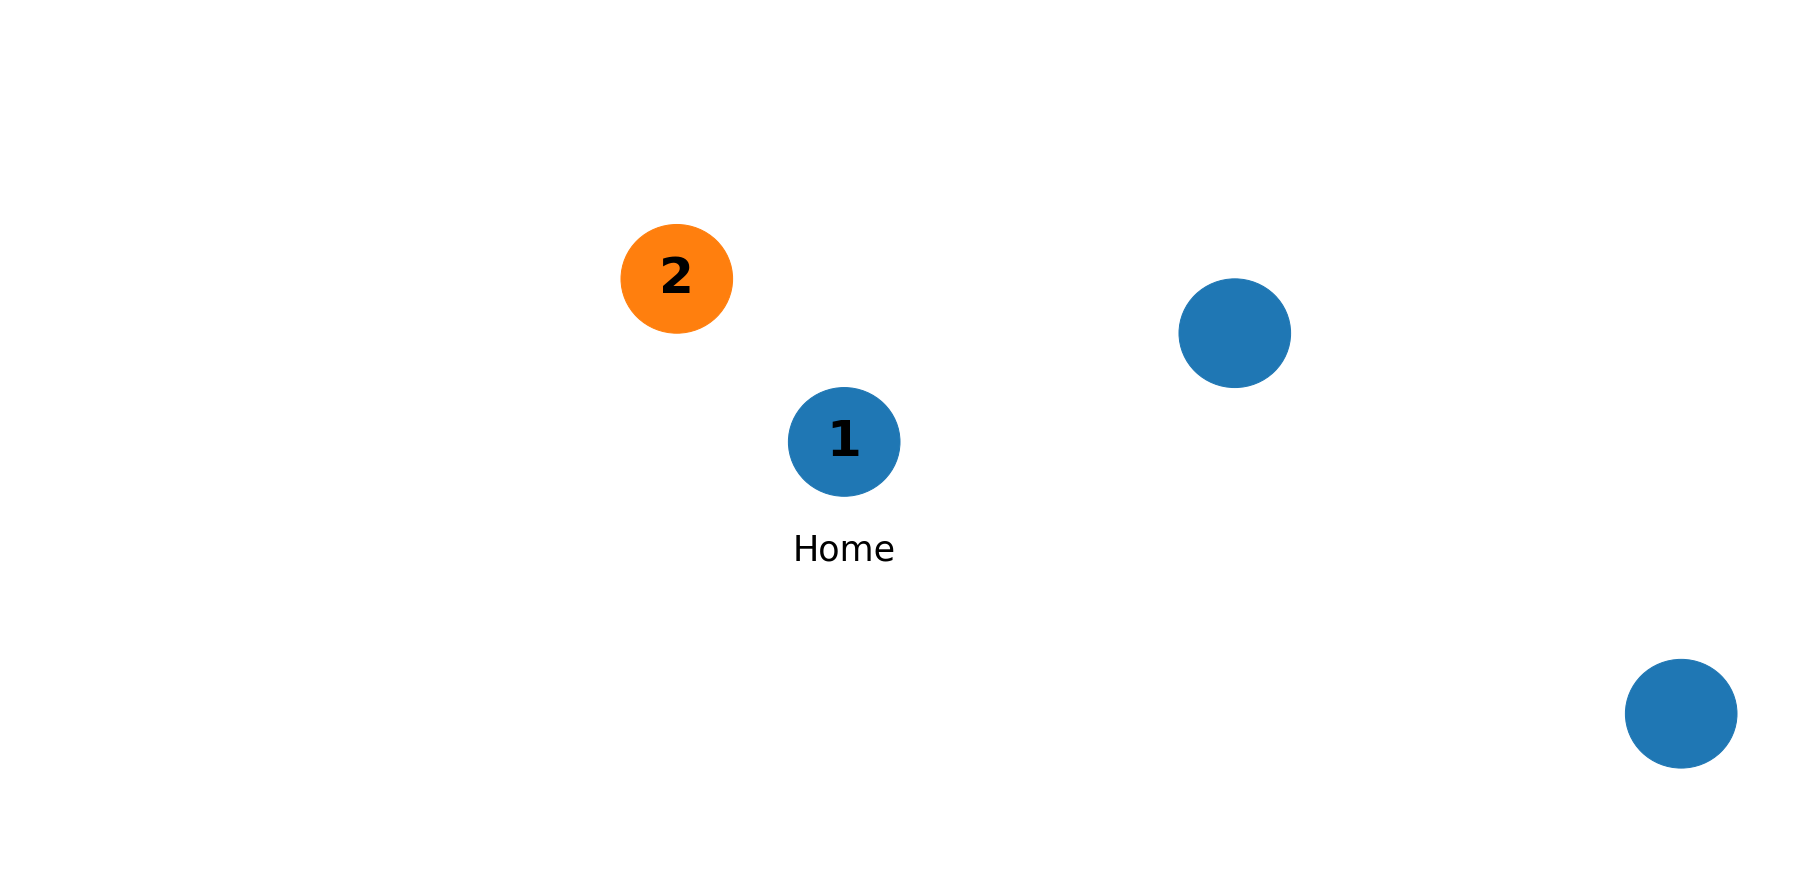

In [13]:
ax = plot(uniform_size(visitation_freq(), 1), 2)
mark_place(ax, "1", home_location)
mark_place(ax, "2", 2)

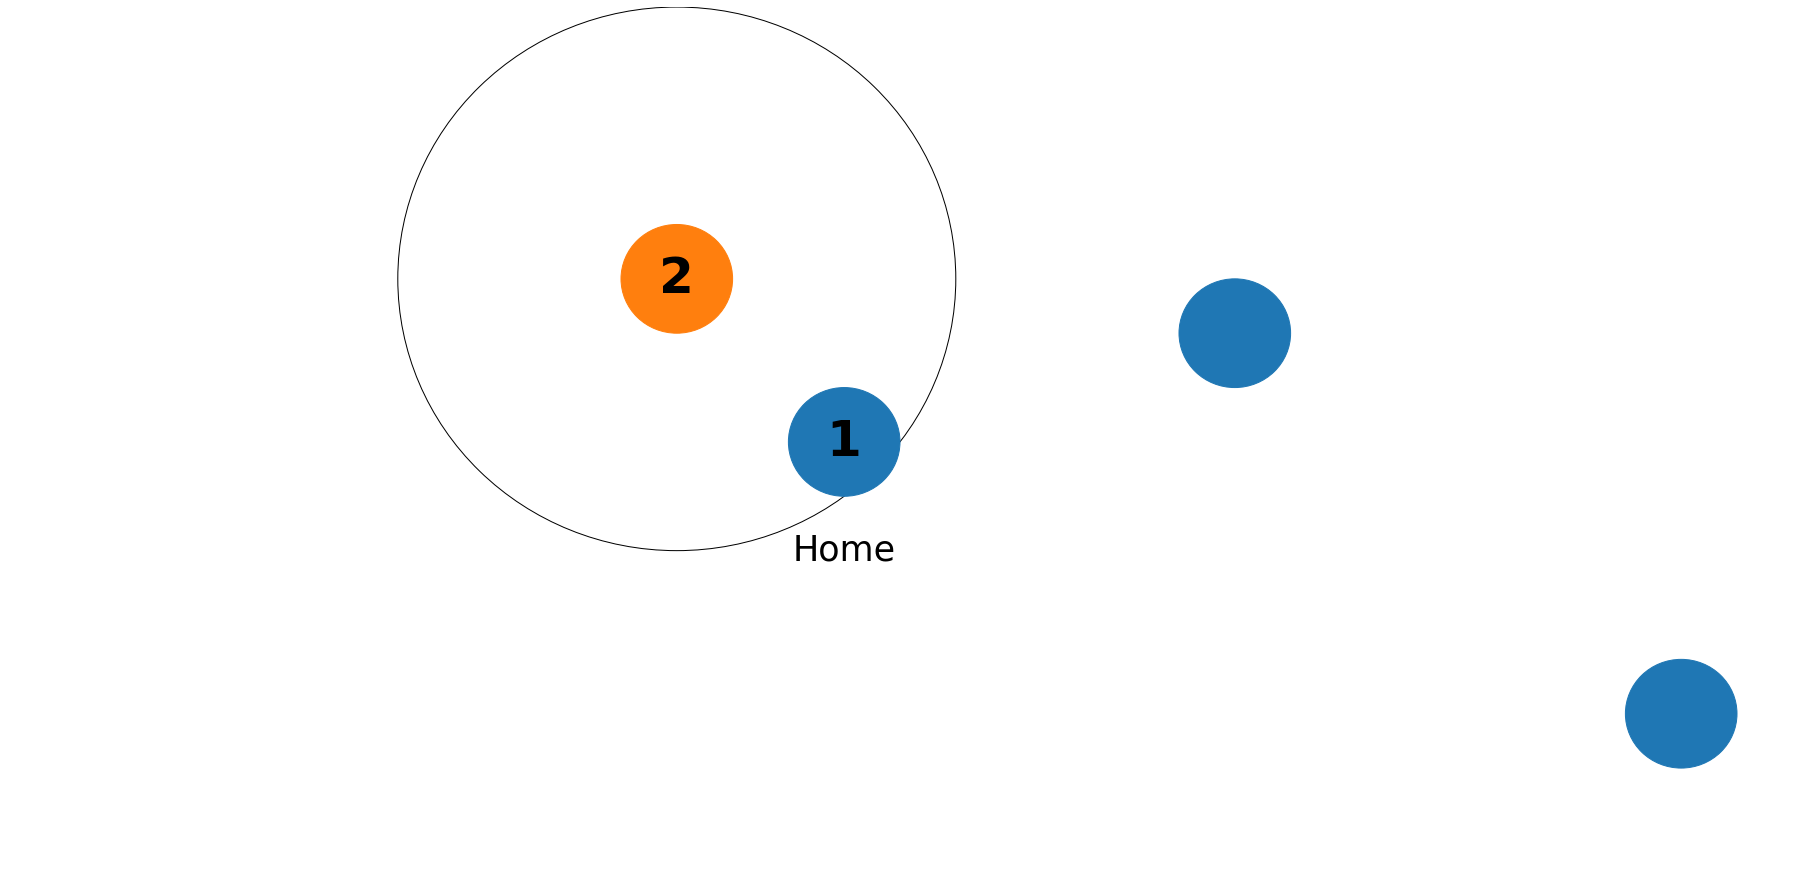

In [14]:
ax = plot(uniform_size(visitation_freq(), 1), 2)
ax.add_artist(mpl.patches.Circle(places[2], 5, edgecolor='black', facecolor='none', zorder=-1))
mark_place(ax, "1", home_location)
mark_place(ax, "2", 2)

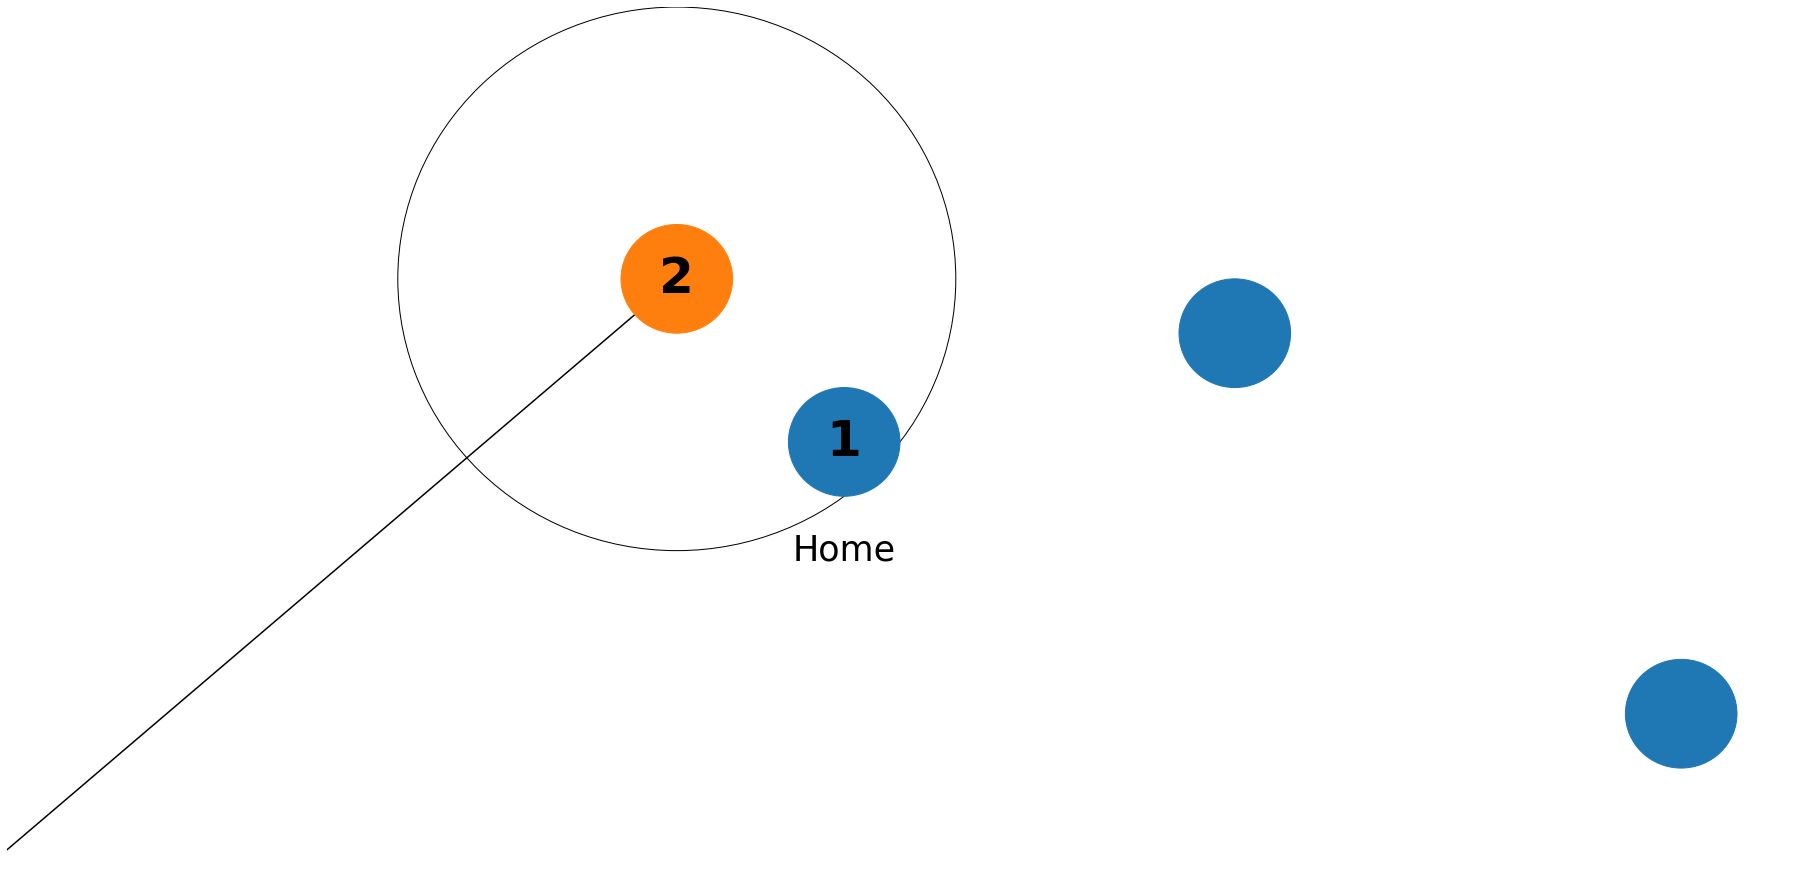

In [15]:
ax = plot(uniform_size(visitation_freq(), 1), 2)

ax.add_artist(mpl.patches.Circle(places[2], 5, edgecolor='black', facecolor='none', zorder=-1))
ax.plot(
    [places[2][0], 0],
    [places[2][1], 2.5],
    color='black',
    zorder=-1,
)
mark_place(ax, "1", home_location)
mark_place(ax, "2", 2)

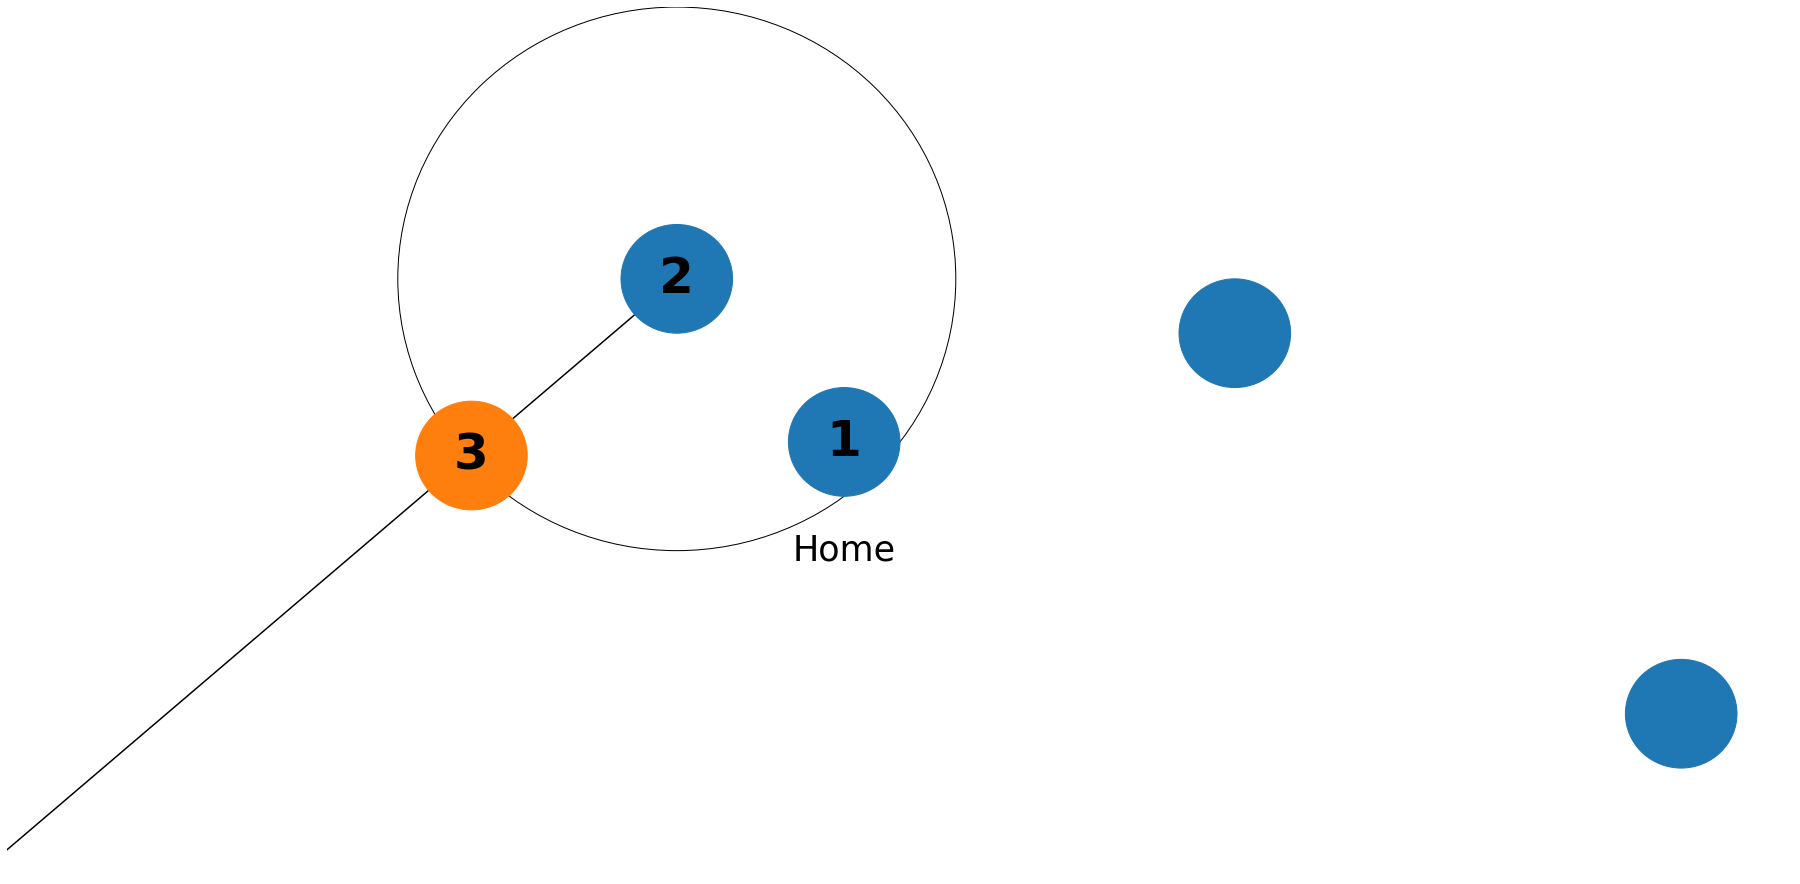

In [16]:
ax = plot(uniform_size(visitation_freq(), 1))
nx = 8.32
ny = 9.75
ax.add_artist(mpl.patches.Circle((nx, ny), 1, color="C1"))
mark_place(ax, "1", home_location)
mark_place(ax, "2", 2)
mark(ax, "3", nx, ny)

ax.add_artist(mpl.patches.Circle(places[2], 5, edgecolor='black', facecolor='none', zorder=-1))
ax.plot(
    [places[2][0], 0],
    [places[2][1], 2.5],
    color='black',
    zorder=-1,
)

# Two-phase gridsearch

In [17]:
def bell(x):
    return np.exp(x) / (1 + np.exp(x))**2

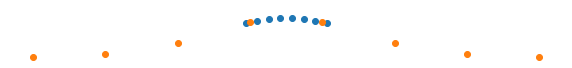

In [18]:
x = np.linspace(-5,5, 8)
y = bell(x)

x2 = np.linspace(-.8,.8, 8)
y2= bell(x2)

fig, ax = plt.subplots(1,1, figsize=(10,1))
ax.scatter(x2,y2)
ax.scatter(x,y)
ax.set_axis_off()

In [102]:
places = [
    (2, 3.5),
    (5, 1),
    (1, 5),
]

home_location = 0
visits = np.array([14, 10, 8])
distances = pairwise_distances(places)

In [160]:
def visitation_freq():
    visitation_f = visits / np.sum(visits)
    pl = []
    for i, (x,y) in enumerate(places):
        size = visitation_f[i] * 2
        pl.append((
            x, y, 
            size, 
            (),
        ))
    return pl
    
    
def preferential_return(from_index):
    d = distances[from_index]
    impedance = np.exp(-0.55 * d)
    impedance = impedance / np.sum(impedance)
    visitation_freq = visits / np.sum(visits)
    s = impedance * visitation_freq
    s[from_index] = 0.05
    s = s / np.sum(s)
    
    pl = []
    for i, (x,y) in enumerate(places):
        size = 2*s[i]
        pl.append((
            x, y, 
            size, 
            (impedance[i], visitation_freq[i]),
        ))
    return pl

def uniform_size(state, size):
    n = []
    for (x,y,s,info) in state:
        n.append((x,y,size,info))
    return n

def plot(ax, state, current_place=None):
    ax.set_xlim(0,6)
    ax.set_ylim(0,6)
    ax.set_xticks([])
    ax.set_yticks([])
    
    for i, (x, y, d, _) in enumerate(state):
        c = "C0"
        if current_place is not None and i == current_place:
            c = "C1"
        ax.add_artist(mpl.patches.Circle((x,y), d, color=c))
        if i == home_location:
            ax.text(x, y-d-0.3, "Home", fontsize=15, ha="center", va="center")
    return ax

def mark(ax, text, x, y):
    ax.text(x, y, text, fontsize=25, ha="center", va="center", fontweight="bold")
    
def mark_place(ax, text, place_index):
    mark(ax, text, places[place_index][0], places[place_index][1])

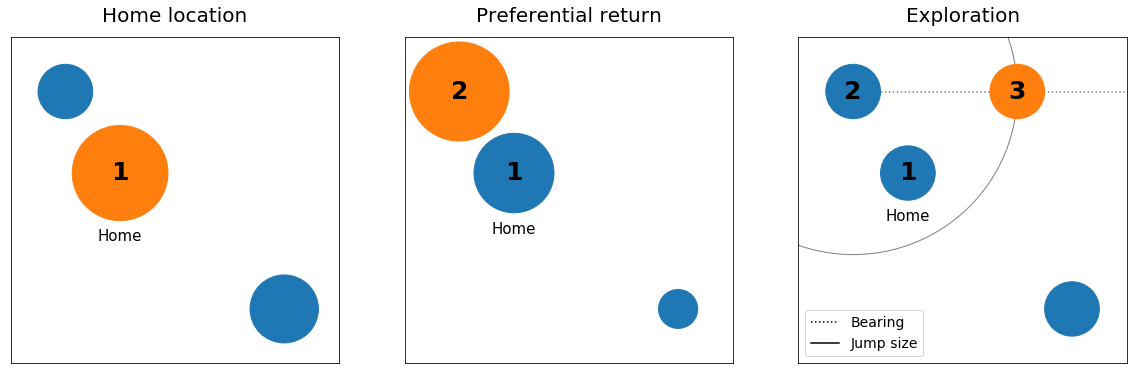

In [185]:
fig, axes = plt.subplots(1,3, figsize=(20,6))

# Home location
plot(axes[0], visitation_freq(), home_location)
mark_place(axes[0], "1", home_location)

# Preferential return
plot(axes[1], preferential_return(home_location), 2)
mark_place(axes[1], "1", home_location)
mark_place(axes[1], "2", 2)

# Exploration
plot(axes[2], uniform_size(visitation_freq(), .5))
nx = 4
ny = 5

mark_place(axes[2], "1", home_location)
mark_place(axes[2], "2", 2)
mark(axes[2], "3", nx, ny)

axes[2].add_artist(mpl.patches.Circle(
    (nx, ny), 
    .5, 
    color="C1",
))
axes[2].add_artist(mpl.patches.Circle(
    places[2],
    3, 
    edgecolor='grey', 
    facecolor='none', 
    zorder=-1,
    ls="-",
))

axes[2].plot(
    [places[2][0], 6],
    [places[2][1], 5],
    color='grey',
    zorder=-1,
    ls="dotted",
)

axes[2].legend(
    handles=[
        mpl.lines.Line2D([], [], color='black', ls='dotted', markersize=15, label='Bearing'),
        mpl.lines.Line2D([], [], color='black', ls='-', markersize=15, label='Jump size'),
    ],
    fontsize=14,
    loc='lower left'
)

for (ax, title) in zip(axes, ["Home location", "Preferential return", "Exploration"]):
    ax.set_title(title, fontsize=20, pad=15)